In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from tqdm import tqdm

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
import scipy

In [3]:
DATA_FOLDER='./data/'
PATHS_AND_GRAPH = DATA_FOLDER + 'wikispeedia_paths-and-graph/'
PATHS_FINISHED = PATHS_AND_GRAPH + 'paths_finished.tsv'
PATHS_UNFINISHED = PATHS_AND_GRAPH + 'paths_unfinished.tsv'

In [4]:
#data exploration
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [5]:
import os
os.listdir('./data')

['wikispeedia_paths-and-graph']

In [6]:
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


## BERTscore semantic similarity metric on data

In [7]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER") # Named entity recognition-specific model!

def compute_sim(s1, s2):
	enc1 = tokenizer.encode(s1, return_tensors='pt').reshape(1, -1)
	enc2 = tokenizer.encode(s2, return_tensors='pt').reshape(1, -1)

	trunc = min(enc1.size(dim=1), enc2.size(dim=1))

	enc1 = enc1[:, :trunc]
	enc2 = enc2[:, :trunc]

	return cosine_similarity(enc1, enc2).squeeze().item()

In [8]:
compute_sim('That\'s cool bro!', 'Yeah, thanks man.')

0.17891668381127587

In [9]:
compute_sim('I am 6 years old', 'I am 10 years old')

0.9178431127887152

In [10]:
sucessive_pairs = [[(x.split(';')[i], x.split(';')[i+1]) for i in range(len(x.split(';')) - 1)] for x in paths_finished['path'].to_list()]
print(sucessive_pairs[:2])

[[('14th_century', '15th_century'), ('15th_century', '16th_century'), ('16th_century', 'Pacific_Ocean'), ('Pacific_Ocean', 'Atlantic_Ocean'), ('Atlantic_Ocean', 'Accra'), ('Accra', 'Africa'), ('Africa', 'Atlantic_slave_trade'), ('Atlantic_slave_trade', 'African_slave_trade')], [('14th_century', 'Europe'), ('Europe', 'Africa'), ('Africa', 'Atlantic_slave_trade'), ('Atlantic_slave_trade', 'African_slave_trade')]]


In [11]:
sucessive_pairs_encoded = [[compute_sim(*a) for a in x] for x in tqdm(sucessive_pairs)]

100%|██████████| 51318/51318 [02:14<00:00, 382.66it/s]


In [12]:
sucessive_pairs_encoded_mean = [np.mean(x) for x in sucessive_pairs_encoded]
sucessive_pairs_encoded_mean[:5]

/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


[0.7284729586204293,
 0.996099050367021,
 0.9189520328545707,
 0.9999213535320469,
 0.8641020573853648]

/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 11 rows containing non-finite values.


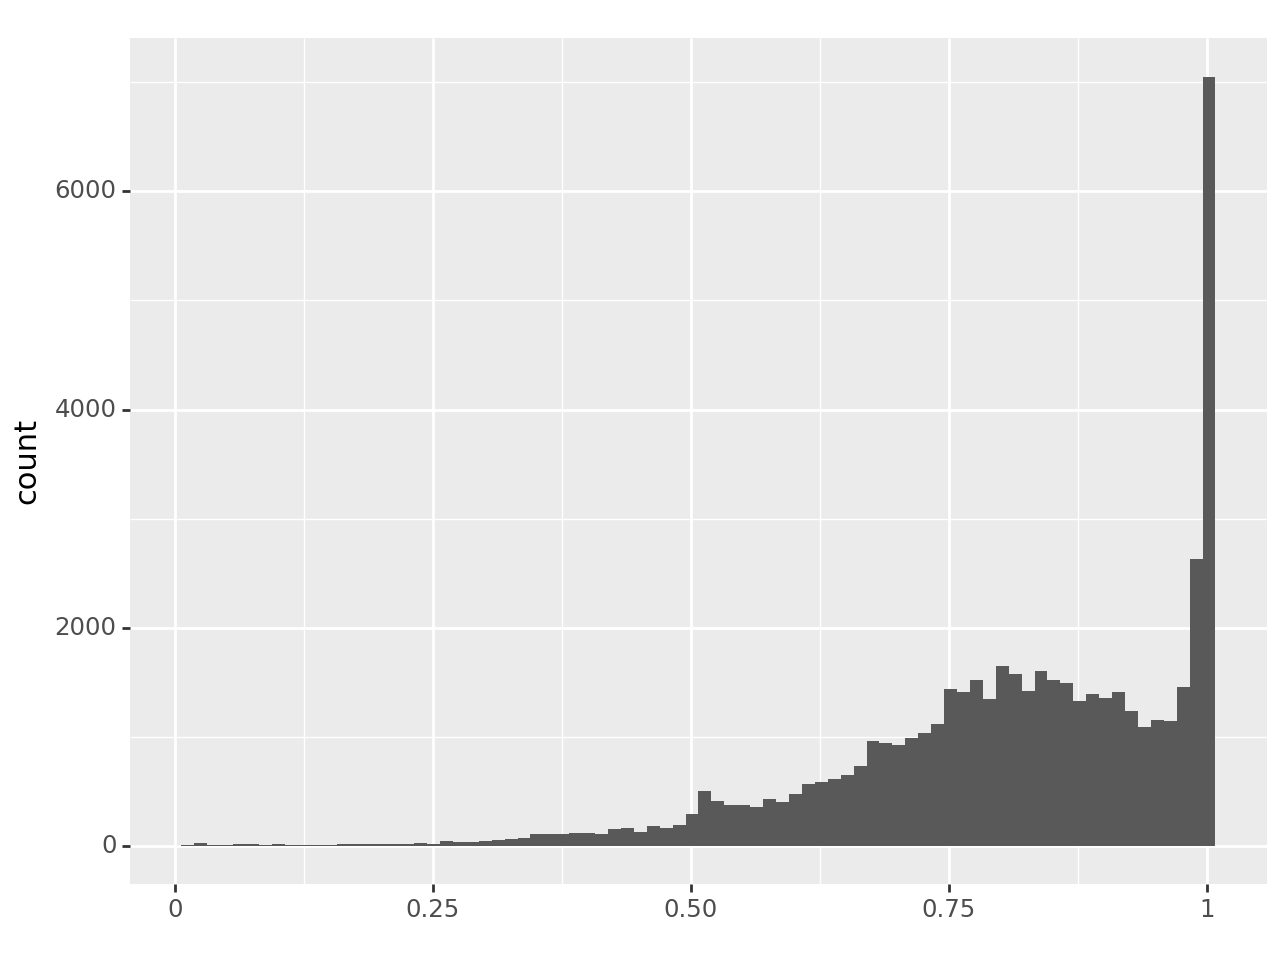

<Figure Size: (640 x 480)>

In [14]:
ggplot() + geom_histogram(aes(x=sucessive_pairs_encoded_mean), bins=80)

Awesome. This looks like another metric we could use! Looks mostly Gaussian. Maybe we should look into all those values close to 1. All the rest is nice though!

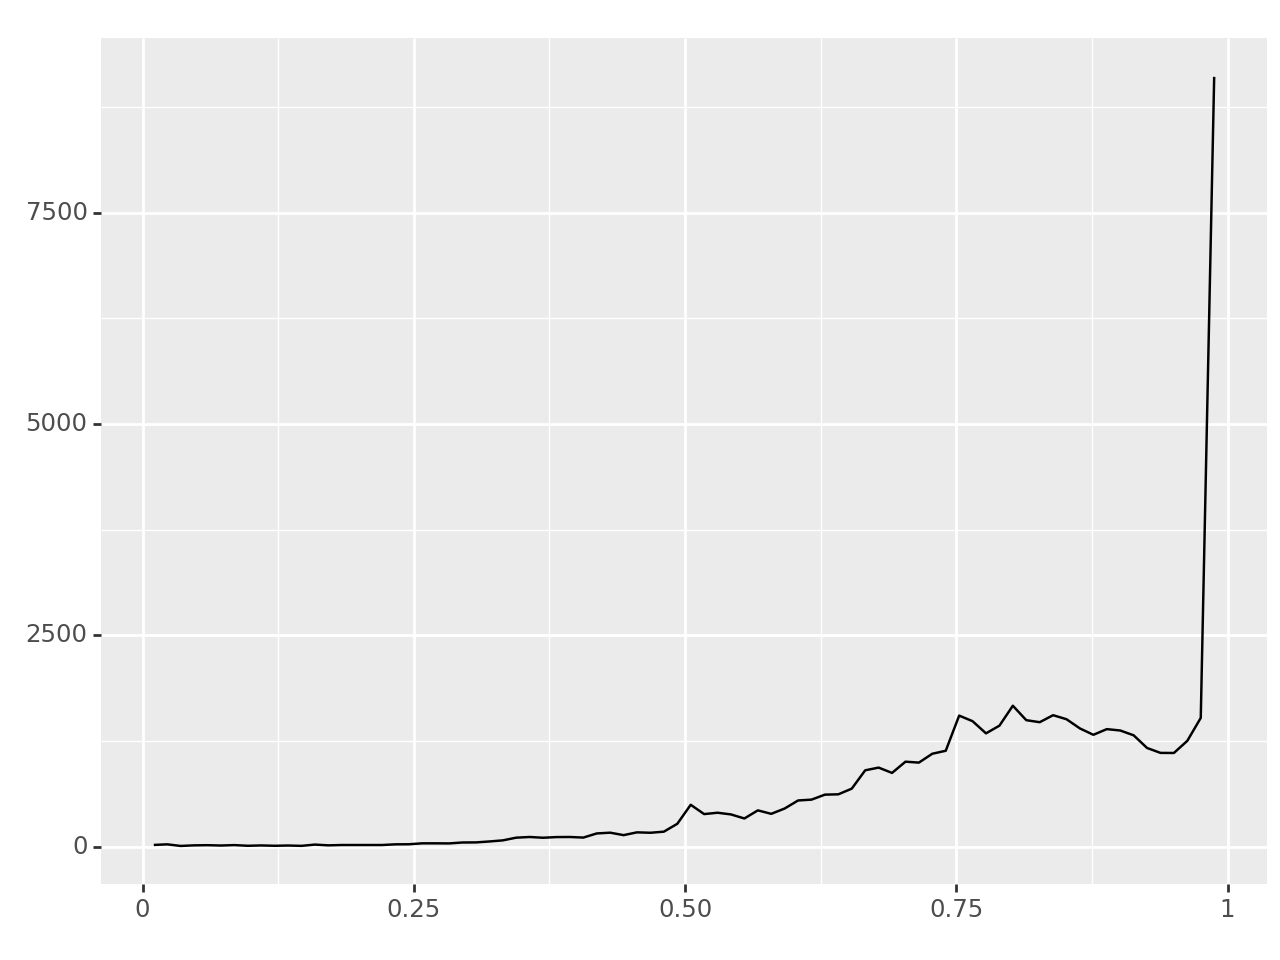


'Gaussianity' shaprio test p-value: 2.401617079305588e-15


In [21]:
sucessive_pairs_encoded_mean = np.array(sucessive_pairs_encoded_mean)
sucessive_pairs_encoded_mean = sucessive_pairs_encoded_mean[~np.isnan(sucessive_pairs_encoded_mean)]

np_hist = np.histogram(sucessive_pairs_encoded_mean, bins=80)

print(ggplot(aes(x=np_hist[1][:-1], y=np_hist[0])) + geom_line())

print("'Gaussianity' shaprio test p-value:", scipy.stats.shapiro(np_hist[0]).pvalue)